In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
df = pd.read_csv('../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [24]:
def MARE(prediction_tensor, truth_tensor):
    return torch.sum(torch.abs((prediction_tensor - truth_tensor)/truth_tensor))/truth_tensor.numel()

In [25]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [26]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [27]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [28]:
# Split the data into train, val, test (60-20-20)

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece[0:int(n*0.6)]
val_df1 = first_piece[int(n*0.6):int(n*0.8)]
test_df1 = first_piece[int(n*0.8):]


In [29]:
# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
val_df1 = (val_df1 - train_mean1) / train_std1
test_df1 = (test_df1 - train_mean1) / train_std1

In [30]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])   # Sequence of `seq_length`
        targets.append(data[i+seq_length])       # Next value as target
    
    return np.array(sequences), np.array(targets)

In [31]:
train_seq1, train_labels1 = create_sequences(train_df1.values, 12)
val_seq1, val_labels1 = create_sequences(val_df1.values, 12)
test_seq1, test_labels1 = create_sequences(test_df1.values, 12)

In [32]:
# Convert to PyTorch tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1)  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1) # (batch, output_dim)
val_seq_tensor1 = torch.FloatTensor(val_seq1)  # (batch, seq_length, input_dim)
val_label_tensor1 = torch.FloatTensor(val_labels1)  # (batch, output_dim)
test_seq_tensor1 = torch.FloatTensor(test_seq1)  # (batch, seq_length, input_dim)
test_labels_tensor1 = torch.FloatTensor(test_labels1)  # (batch, output_dim)

In [33]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 50
num_layers = 2
output_dim = 1

# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to("cpu")  # Use "cuda" if you have a GPU


In [34]:
class SoftPeakLocationLoss(nn.Module):
    """
    Combines:
      - Mean Squared Error (MSE) for overall fit
      - Soft peak location penalty for aligning predicted peak time with the true peak time
    """
    def __init__(self, temperature=1.0, alpha_mse=1.0, alpha_peak_time=1.0):
        """
        Args:
            temperature (float): Temperature for the softmax-like operation.
                                Smaller = more 'argmax'-like, but less stable gradients.
            alpha_mse (float): Weight (coefficient) for the MSE term.
            alpha_peak_time (float): Weight (coefficient) for the peak time alignment term.
        """
        super().__init__()
        self.temperature = temperature
        self.alpha_mse = alpha_mse
        self.alpha_peak_time = alpha_peak_time
    
    def forward(self, y_pred, y_true):
        """
        Args:
            y_pred (Tensor): Predicted values (1D tensor of length N).
            y_true (Tensor): Ground truth values (1D tensor of length N).
        
        Returns:
            loss (Tensor): Scalar loss value.
        """
        # 1) Standard MSE loss
        mse_loss = torch.mean((y_true - y_pred)**2)
        
        # 2) Find the true peak time t_true (discrete argmax)
        #    We'll convert to float for a continuous value
        t_true = torch.argmax(y_true).float()
        
        # 3) Compute the "soft peak" index (differentiable argmax approximation)
        #    exp(y_pred / T) for each index, then weighted sum of indices.
        indices = torch.arange(len(y_pred), device=y_pred.device, dtype=y_pred.dtype)
        
        # softmax weights
        weights = torch.exp(y_pred / self.temperature)
        weights_sum = torch.sum(weights)
        
        # soft peak location, \tilde{t}
        t_soft = torch.sum(indices * weights) / (weights_sum + 1e-8)
        
        # 4) Peak time penalty: squared difference between t_soft and t_true
        peak_time_loss = (t_soft - t_true)**2
        
        # 5) Total loss = alpha_mse * MSE + alpha_peak_time * peak_time_loss
        loss = self.alpha_mse * mse_loss + self.alpha_peak_time * peak_time_loss
        return loss

In [35]:
# Instantiate the custom loss
temperature = 0.5      # smaller T => more "argmax"-like
alpha_mse = 1.0
alpha_peak_time = 5.0  # place a higher emphasis on correct peak time
criterion = SoftPeakLocationLoss(temperature, alpha_mse, alpha_peak_time)

In [36]:
optimizer = optim.Adam(model1.parameters(), lr=0.01)

In [37]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model1.train()
    
    optimizer.zero_grad()
    y_pred = model1(train_seq_tensor1)
    
    loss = criterion(y_pred, train_label_tensor1)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    # Validation
    model1.eval()
    with torch.no_grad():
        y_val = model1(val_seq_tensor1)
        val_loss = criterion(y_val, val_label_tensor1)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 134888208.0, Val Loss: 616010.75
Epoch 10, Train Loss: 134888176.0, Val Loss: 616009.9375
Epoch 20, Train Loss: 134888144.0, Val Loss: 616010.375
Epoch 30, Train Loss: 134888144.0, Val Loss: 616010.125
Epoch 40, Train Loss: 134888176.0, Val Loss: 616009.8125
Epoch 50, Train Loss: 134888208.0, Val Loss: 616010.0
Epoch 60, Train Loss: 134888176.0, Val Loss: 616010.3125
Epoch 70, Train Loss: 134888176.0, Val Loss: 616010.0625
Epoch 80, Train Loss: 134888208.0, Val Loss: 616010.3125
Epoch 90, Train Loss: 134888176.0, Val Loss: 616010.3125


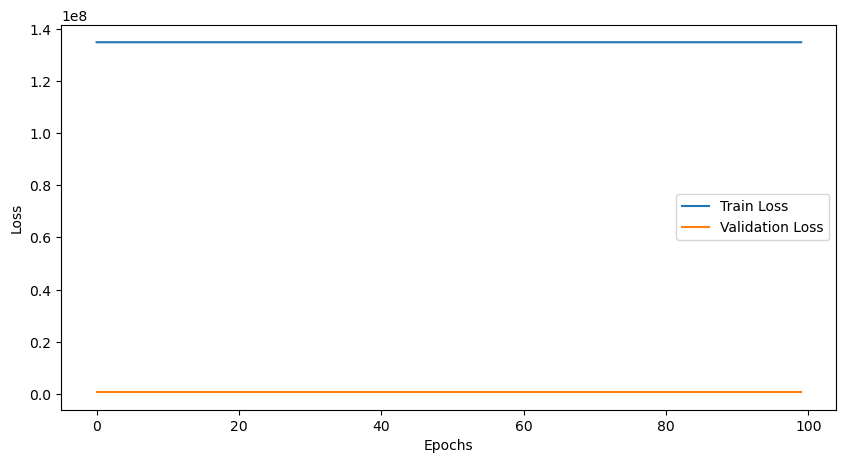

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


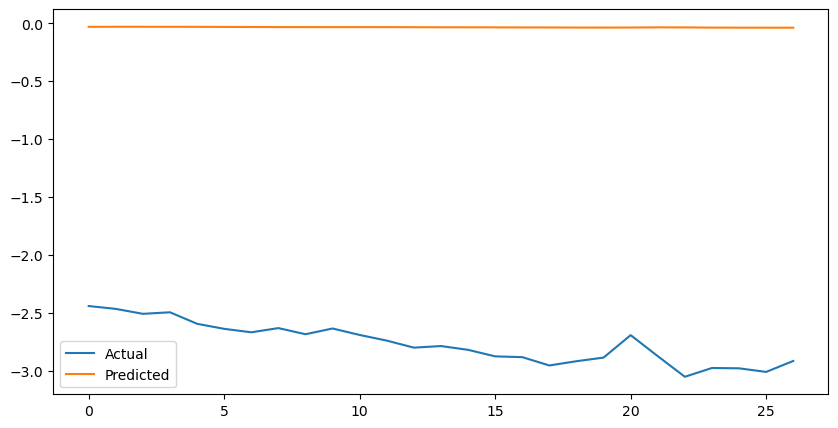

In [39]:
model1.eval()
with torch.no_grad():
    y_pred_test = model1(test_seq_tensor1)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor1.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()
